In [1]:
import os
import sys

In [2]:
os.chdir('/home/au643300/DataHandling/')
sys.path.append('/home/au643300/DataHandling/')
os.environ['HDF5_USE_FILE_LOCKING']="FALSE"

In [3]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, as_completed,wait,fire_and_forget,progress
import glob
from src.data.tonetCDF import to_netcdf
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from src.interim import read_valdata
import numpy as np
import importlib
import dask
import zarr
import time
from rechunker import rechunk

In [4]:
def custom_optimize(dsk, keys):
    dsk = dask.optimization.inline(dsk, inline_constants=True)
    return dask.array.optimization.optimize(dsk, keys)
sns.set_theme()
dask.config.set({"distributed.comm.timeouts.tcp": "50s"})
dask.config.set({'distributed.comm.retry.count':3})
dask.config.set({'distributed.comm.timeouts.connect':'25s'})
dask.config.set({"distributed.worker.use-file-locking":False})
zarr.blosc.use_threads = False

In [5]:
cluster=SLURMCluster(cores=4,
                     memory="12GB",
                     queue='q64',
                     walltime='0-06:00:00',
                     local_directory='/scratch/$SLURM_JOB_ID',
                     interface='ib0',
                     scheduler_options={'interface':'ib0'},
                     extra=['--resources mem=15',"--lifetime", "340m", "--lifetime-stagger", "4m"]
                    )
                    

In [6]:
client=Client(cluster)

In [7]:
cluster.adapt(minimum=1,maximum=2)

In [8]:
client

Client Scheduler: tcp://10.100.8.23:46506 Dashboard: http://10.100.8.23:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
files=glob.glob("/home/au643300/NOBACKUP/interim/*nc")
files=files[0]
ds=xr.open_zarr("/home/au643300/NOBACKUP/data.zarr/")
ds

,Array,Chunk
Bytes,71.77 GB,105.38 MB
Shape,"(681, 256, 201, 256)","(1, 256, 201, 256)"
Count,682 Tasks,681 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,71.77 GB,105.38 MB
Shape,"(681, 256, 201, 256)","(1, 256, 201, 256)"
Count,682 Tasks,681 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [23]:
with dask.config.set(array_optimize=custom_optimize):
    mean=ds.mean()
    mean=dask.optimize(mean)[0]

In [11]:
meanu=mean.u_vel

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.288788 to fit


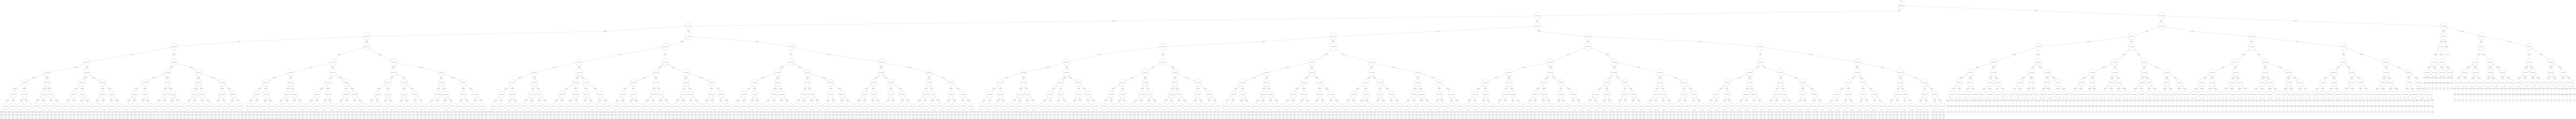

In [12]:
k=meanu.data
k.visualize()

In [24]:
a=client.compute(mean)